In [29]:
library(repr)
library(tidyverse)
library(splines)
library(arrow)
library(gridExtra)


Attaching package: ‘gridExtra’


The following object is masked from ‘package:dplyr’:

    combine




# Data load

In [298]:
data <- read_feather('data/CovidCastState.feather')[,1:7]

In [299]:
data

geo_value,time_value,deaths,completely_home_prop,median_home_dwell_time,full_time_work_prop,part_time_work_prop
<chr>,<dttm>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
ak,2020-01-21 19:00:00,0,0.2222627,477.5670,0.06812638,0.1238832
al,2020-01-21 19:00:00,0,0.1716191,625.1579,0.11374880,0.1767434
ar,2020-01-21 19:00:00,0,0.2032478,654.4188,0.09237672,0.1490201
as,2020-01-21 19:00:00,NA,0.1974206,758.5000,0.14186508,0.1974206
az,2020-01-21 19:00:00,0,0.2257108,651.8253,0.07969418,0.1247258
ca,2020-01-21 19:00:00,0,0.2054381,650.8295,0.07101119,0.1302186
co,2020-01-21 19:00:00,0,0.2254466,621.4551,0.10558878,0.1478236
ct,2020-01-21 19:00:00,0,0.2087841,613.8510,0.11711040,0.1435239
dc,2020-01-21 19:00:00,0,0.2471849,481.1403,0.10040326,0.1124296


In [300]:
regions = (
    data %>%
    count(geo_value) %>%
    filter(!(geo_value %in% c('ak','hi','as','gu','mp','vi','mt','sd','wy')))
)$geo_value

In [301]:
regions; length(regions)

[1] "al" "ar" "az" "ca" "co" "ct" "dc" "de" "fl" "ga" "ia" "id" "il" "in" "ks"
[16] "ky" "la" "ma" "md" "me" "mi" "mn" "mo" "ms" "nc" "nd" "ne" "nh" "nj" "nm"
[31] "nv" "ny" "oh" "ok" "or" "pa" "pr" "ri" "sc" "tn" "tx" "ut" "va" "vt" "wa"
[46] "wi" "wv"

[1] 47

# Adjust weekend effects

In [302]:
adjust_we <- function(time_value, y, family="gaussian", rm.zero=FALSE){
    n_zero = 0
    if(rm.zero){
        n_zero = sum(cumsum(y) < 1)
        time_value = time_value[cumsum(y) > 0]
        y = y[cumsum(y) > 0]
    }
    
    data_we = data.frame(time_value = time_value, y = y) %>%
        mutate(weekday = weekdays(time_value)) %>%
        mutate(X1 = (weekday == 'Sunday') - (weekday == 'Monday'),
               X2 = (weekday == 'Sunday') - (weekday == 'Tuesday'),
               X3 = (weekday == 'Sunday') - (weekday == 'Friday'),
               X4 = (weekday == 'Sunday') - (weekday == 'Saturday'))
    
    data_nwe = data_we %>%
        mutate(X1 = 0, X2 = 0, X3 = 0, X4 = 0)
    
    result_glm = glm(y ~ ns(time_value, 8) * (X1 + X2 + X3 + X4), family = family, data=data_we)
    
    return(c(rep(0, n_zero),
             y - predict(result_glm, type="response") + predict(result_glm, newdata=data_nwe, type="response")))
}

In [303]:
data_adj = data.frame()

In [305]:
for(r in regions){
    print(r)
    
    data_r = data %>% 
    filter(geo_value ==r) %>%
    mutate(deaths = ifelse(is.na(deaths), 0, deaths)) %>%
    mutate(deaths = ifelse(deaths < 0, 0, deaths))
    
    data_ra = data_r %>%
    mutate(deaths_adj = adjust_we(time_value, deaths, family="poisson", rm.zero=TRUE))
#            completely_home_prop = adjust_we(time_value, completely_home_prop),
#            median_home_dwell_time = adjust_we(time_value, median_home_dwell_time),
#            full_time_work_prop = adjust_we(time_value, full_time_work_prop),
#            part_time_work_prop = adjust_we(time_value, part_time_work_prop))
    
    data_adj = rbind(data_adj, data_ra)
}

[1] "al"
[1] "ar"
[1] "az"
[1] "ca"
[1] "co"
[1] "ct"
[1] "dc"
[1] "de"
[1] "fl"
[1] "ga"
[1] "ia"
[1] "id"
[1] "il"
[1] "in"
[1] "ks"
[1] "ky"
[1] "la"
[1] "ma"
[1] "md"
[1] "me"
[1] "mi"
[1] "mn"
[1] "mo"
[1] "ms"
[1] "nc"
[1] "nd"
[1] "ne"
[1] "nh"
[1] "nj"
[1] "nm"
[1] "nv"
[1] "ny"
[1] "oh"
[1] "ok"
[1] "or"
[1] "pa"
[1] "pr"
[1] "ri"
[1] "sc"
[1] "tn"
[1] "tx"
[1] "ut"
[1] "va"
[1] "vt"
[1] "wa"
[1] "wi"
[1] "wv"


In [171]:
regions

[1] "al" "ar" "az" "ca" "co" "ct" "dc" "de" "fl" "ga" "ia" "id" "il" "in" "ks"
[16] "ky" "la" "ma" "md" "me" "mi" "mn" "mo" "ms" "nc" "nd" "ne" "nh" "nj" "nm"
[31] "nv" "ny" "oh" "ok" "or" "pa" "pr" "ri" "sc" "tn" "tx" "ut" "va" "vt" "wa"
[46] "wi" "wv"

In [ ]:
i = 1

In [426]:
r = regions[i]; r

[1] "wv"

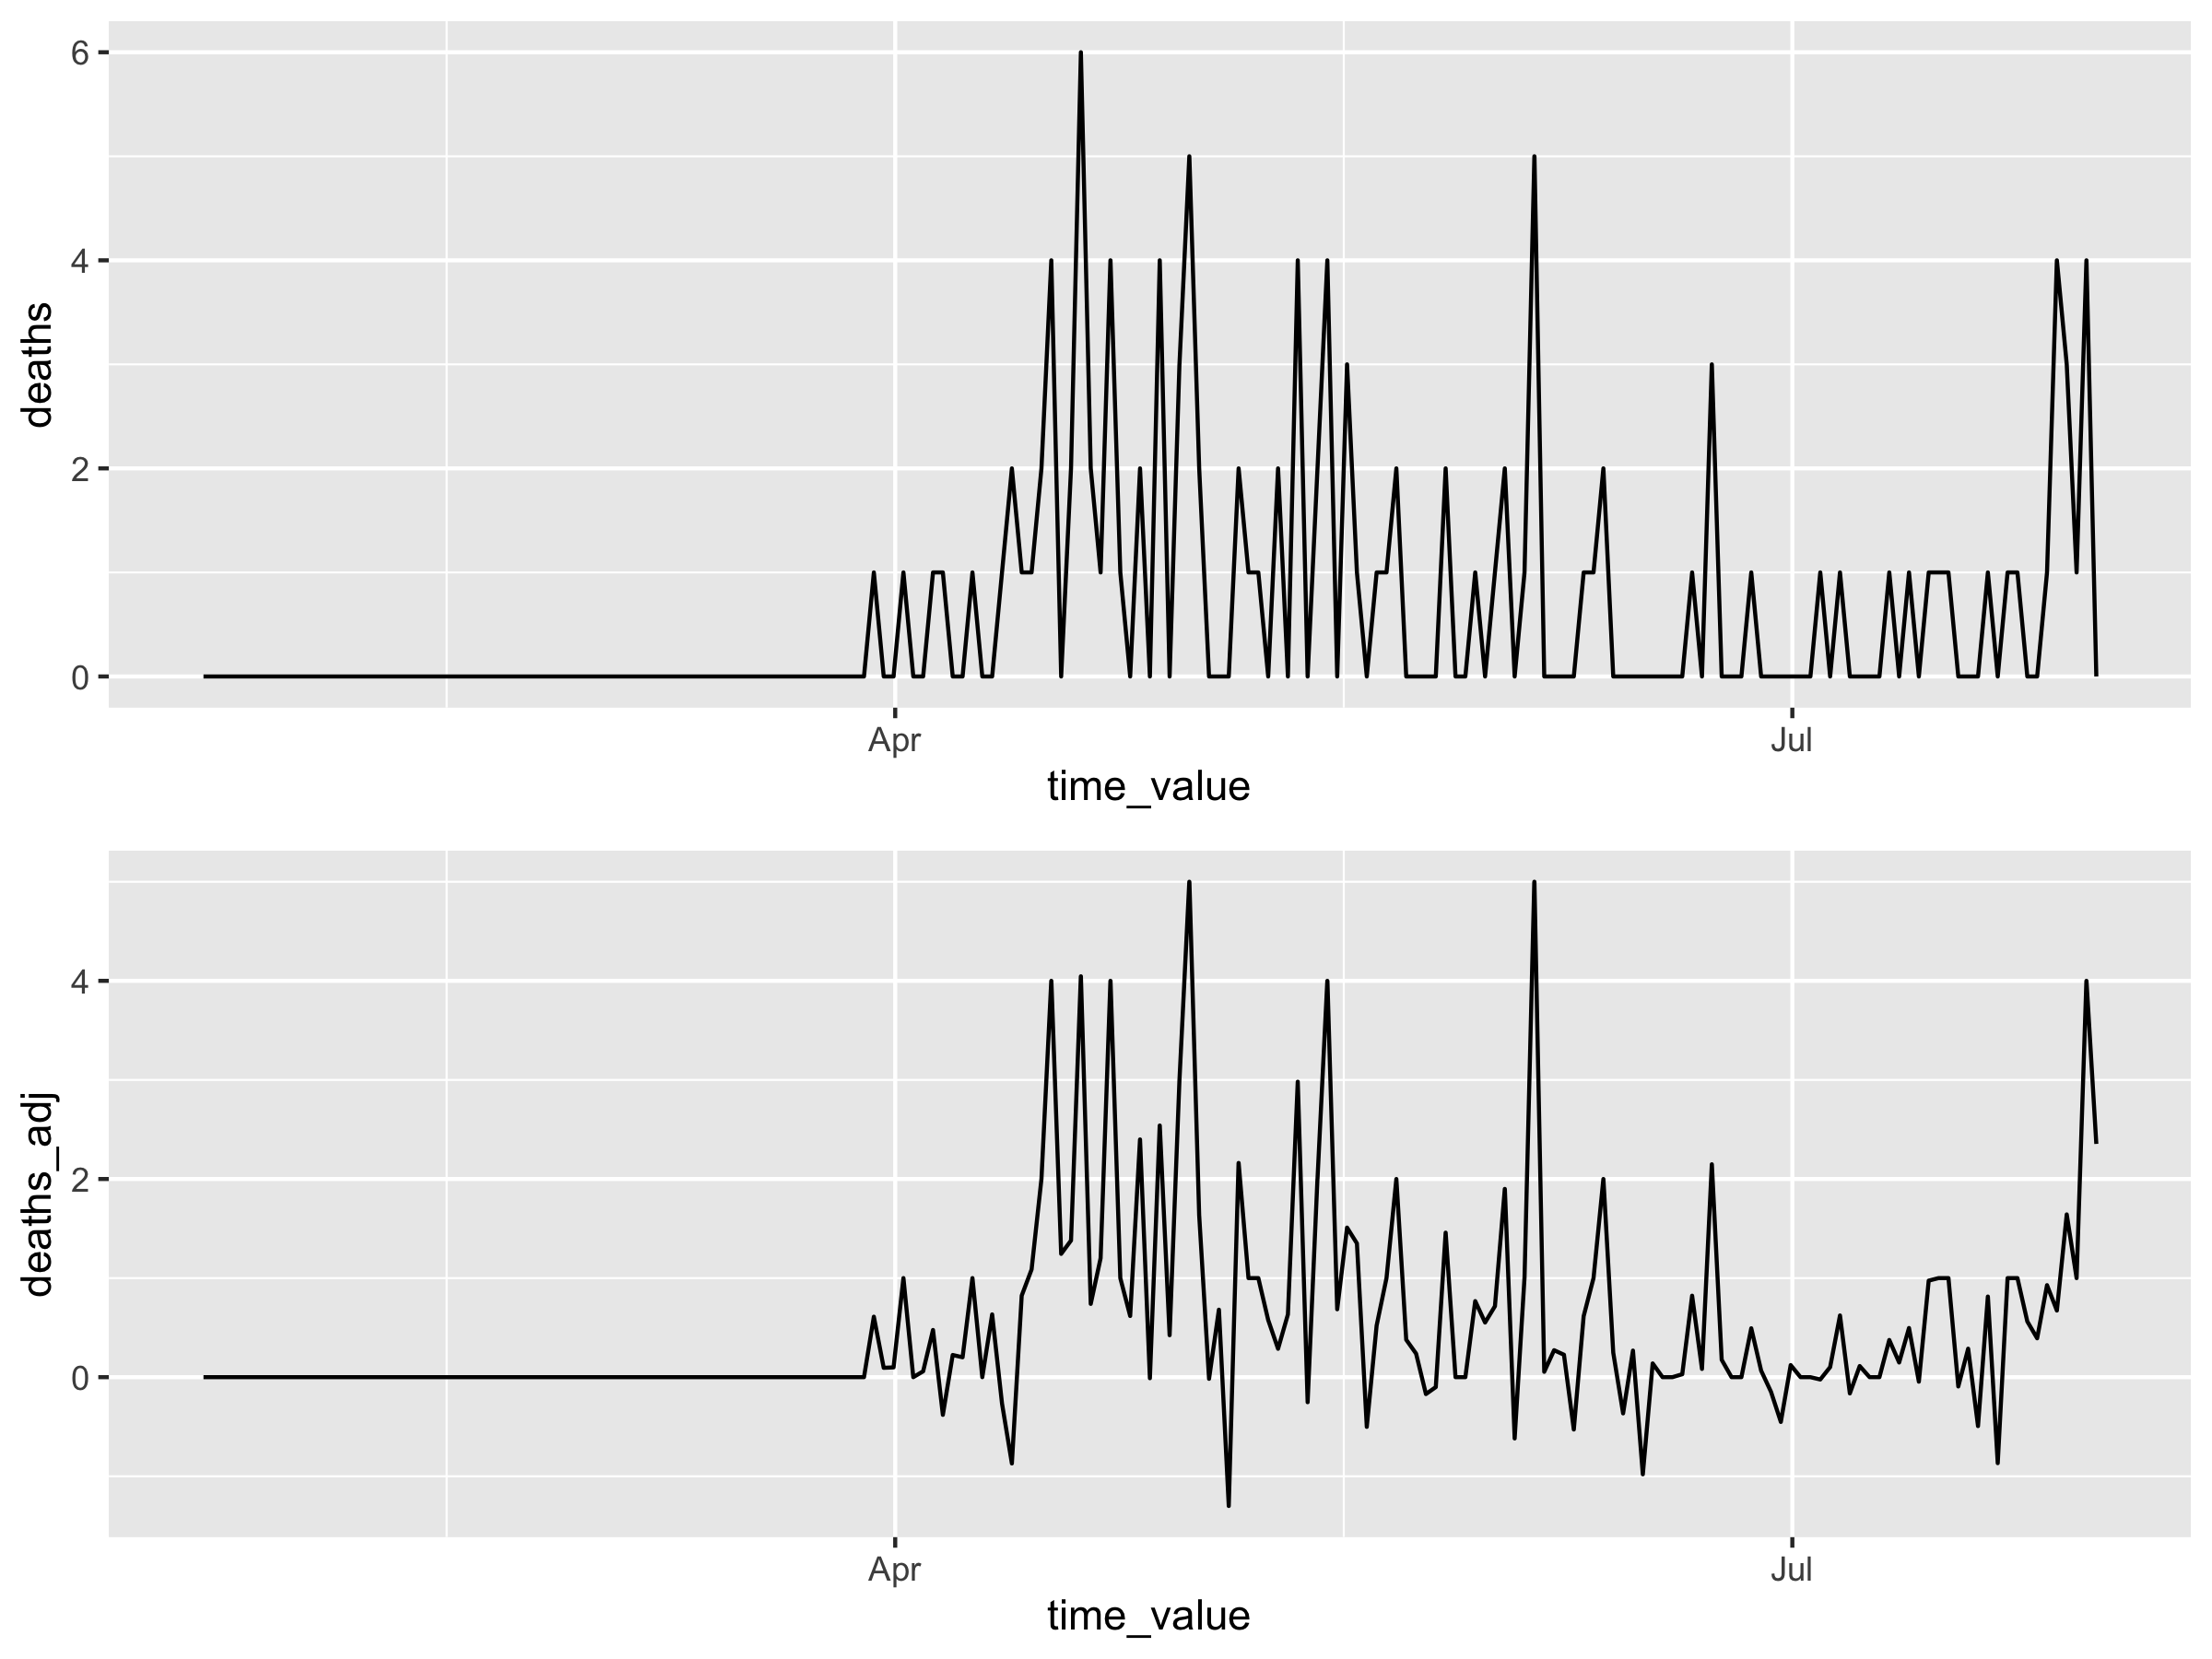

In [427]:
options(repr.plot.width = 8, repr.plot.height = 6, repr.plot.res = 300)

p1 <- data_adj %>%
filter(geo_value == r) %>%
ggplot() +
geom_line(aes(x=time_value, y=deaths))

p2 <- data_adj %>%
filter(geo_value == r) %>%
ggplot() +
geom_line(aes(x=time_value, y=deaths_adj))

grid.arrange(p1, p2, nrow=2)

In [319]:
write_feather(data_adj, 'data/CovidCastStateAdj_2.feather')